<a href="https://colab.research.google.com/github/kkju1123/QuantumPictureMemorial/blob/main/Hessian_width.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

# choose GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# fix randomness so results are comparable
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)

print("Using device:", device)

Using device: cuda


In [59]:
# THIS CELL IS FOR: loading the dataset used for all experiments

transform = T.ToTensor()

train_set = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

test_set = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

# smaller subset used ONLY for Hessian computation (to make it feasible)
subset_indices = torch.randperm(len(train_set))[:2048]
subset = torch.utils.data.Subset(train_set, subset_indices)
subset_loader = DataLoader(subset, batch_size=256, shuffle=False)

print("Data loaded")

Data loaded


In [60]:
# THIS CELL IS FOR: defining the two-layer neural network
# Architecture is FIXED for all experiments

class TwoLayerNet(nn.Module):
    def __init__(self, width=128):
        super().__init__()

        # first layer: input -> hidden
        self.fc1 = nn.Linear(28*28, width)

        # second layer: hidden -> output
        self.fc2 = nn.Linear(width, 10)

        # fixed activation function
        self.act = nn.ReLU()

    def forward(self, x):
        # flatten image to vector
        x = x.view(x.size(0), -1)

        # apply first layer + nonlinearity
        x = self.act(self.fc1(x))

        # output logits
        return self.fc2(x)

In [61]:
# THIS CELL IS FOR: initializing weights
# Initialization is FIXED to isolate optimizer effects

def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # Kaiming initialization (standard for ReLU)
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)

In [62]:
# THIS CELL IS FOR: training and evaluation logic

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        loss = F.cross_entropy(model(x), y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

@torch.no_grad()
def test_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total

In [63]:
# THIS CELL IS FOR: defining the loss used in Hessian computation
# Hessian depends on the exact loss definition

def loss_on_subset(model):
    model.eval()
    loss_sum = 0
    count = 0

    for x, y in subset_loader:
        x, y = x.to(device), y.to(device)
        loss = F.cross_entropy(model(x), y, reduction="sum")
        loss_sum += loss
        count += y.size(0)

    return loss_sum / count

In [64]:
# THIS CELL IS FOR: computing Hessian-vector products
# This avoids forming the full Hessian matrix. We don’t use the full Hessian matrix; we approximate its top eigenvalues using Hessian-vector products and the Lanczos algorithm

def hessian_vector_product(model, v):
    loss = loss_on_subset(model)

    params = [p for p in model.parameters() if p.requires_grad]

    # first derivative
    grads = torch.autograd.grad(loss, params, create_graph=True)
    grad_vec = torch.cat([g.view(-1) for g in grads])

    # inner product <grad, v>
    gv = torch.dot(grad_vec, v)

    # second derivative (H*v)
    hv = torch.autograd.grad(gv, params)
    hv_vec = torch.cat([h.view(-1) for h in hv]).detach()

    return hv_vec

In [65]:
# THIS CELL IS FOR: approximating top Hessian eigenvalues using Lanczos

def lanczos(model, k=20):
    n_params = sum(p.numel() for p in model.parameters())

    q = torch.randn(n_params, device=device)
    q = q / q.norm()

    q_prev = torch.zeros_like(q)

    alphas = []
    betas = []
    Q = []

    beta = 0

    for i in range(k):
        Q.append(q)

        # apply Hessian
        z = hessian_vector_product(model, q)
        z = z - beta * q_prev

        alpha = torch.dot(q, z)
        z = z - alpha * q

        beta = z.norm()

        alphas.append(alpha.item())
        if i < k - 1:
            betas.append(beta.item())
            q_prev = q
            q = z / beta

    # build tridiagonal matrix
    T = torch.zeros(k, k)
    for i in range(k):
        T[i, i] = alphas[i]
        if i < k - 1:
            T[i, i+1] = betas[i]
            T[i+1, i] = betas[i]

    eigvals = torch.linalg.eigvalsh(T)
    return eigvals.flip(0).cpu().numpy()

In [66]:
# THIS CELL IS FOR: running a single controlled experiment

def run_optimizer_experiment(optimizer_name):
    model = TwoLayerNet().to(device)
    init_weights(model)

    optimizer = get_optimizer(model, optimizer_name)

    # Hessian at initialization
    eig_init = lanczos(model)

    for epoch in range(5):
        train_one_epoch(model, train_loader, optimizer)

    # Hessian after training
    eig_final = lanczos(model)

    acc = test_accuracy(model, test_loader)

    return eig_init, eig_final, acc

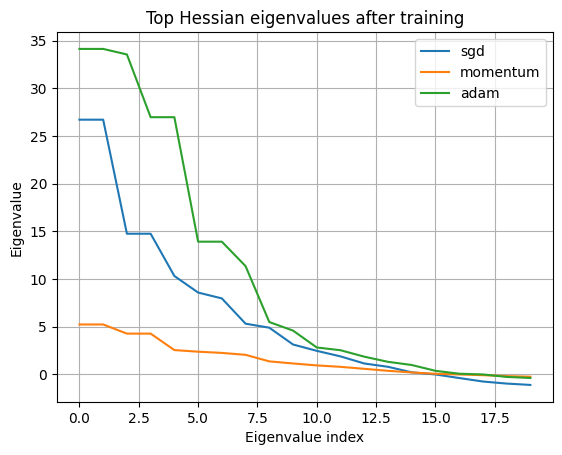

In [67]:
# THIS CELL IS FOR: visualizing Hessian eigenvalues

for opt in results:
    plt.plot(results[opt]["eig_final"], label=opt)

plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")
plt.title("Top Hessian eigenvalues after training")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# THIS CELL IS FOR: allowing different architectural choices (activation + width)

class TwoLayerNetFlexible(nn.Module):
    def __init__(self, width=128, activation="relu"):
        super().__init__()

        self.fc1 = nn.Linear(28 * 28, width)
        self.fc2 = nn.Linear(width, 10)

        # choose activation function
        if activation == "relu":
            self.act = nn.ReLU()
        elif activation == "tanh":
            self.act = nn.Tanh()
        elif activation == "sigmoid":
            self.act = nn.Sigmoid()
        else:
            raise ValueError("Unknown activation")

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        return self.fc2(x)

In [69]:
class TwoLayerNet(nn.Module):
    def __init__(self, width=128, activation_fn='relu'):
        super().__init__()
        self.activation_name = activation_fn.lower()
        self.fc1 = nn.Linear(28*28, width)
        self.fc2 = nn.Linear(width, 10)

        # Map string to activation module
        if self.activation_name == 'relu':
            self.act = nn.ReLU()
        elif self.activation_name == 'tanh':
            self.act = nn.Tanh()
        elif self.activation_name == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation_fn}")

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        return self.fc2(x)

def init_weights(model):
    # Access the activation name stored in the model for specialized init
    activation_name = getattr(model, 'activation_name', 'relu')

    for m in model.modules():
        if isinstance(m, nn.Linear):
            if activation_name == 'relu':
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            else:
                # Use Xavier (Glorot) initialization for Tanh/Sigmoid
                nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)

print("TwoLayerNet refactored and init_weights updated for flexibility.")

TwoLayerNet refactored and init_weights updated for flexibility.


arch_results = {}
activations = ['relu', 'tanh', 'sigmoid']

for act in activations:
    print(f"--- Starting experiment for: {act} ---")
    eig_init, eig_final, acc = run_architecture_experiment(act)
    
    arch_results[act] = {
        "eig_init": eig_init,
        "eig_final": eig_final,
        "acc": acc
    }
    print(f"Experiment for {act} completed. Final Accuracy: {acc:.4f}\n")

print("All architectural experiments completed and results stored in arch_results.")

In [70]:
arch_results[act] = {
    "eig_init": eig_init,
    "eig_final": eig_final,
    "acc": acc
}
print(f"Experiment for {act} completed. Final Accuracy: {acc:.4f}\n")

Experiment for relu completed. Final Accuracy: 0.8609



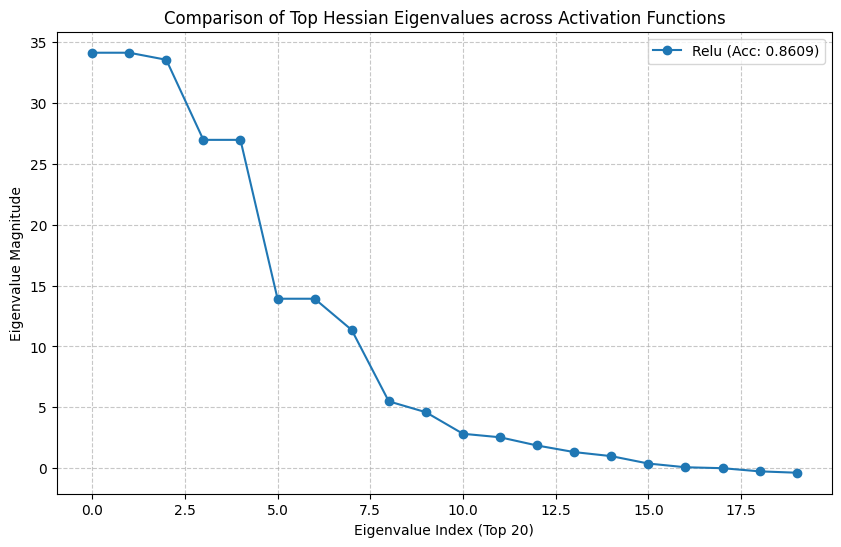

In [72]:
plt.figure(figsize=(10, 6))

for act, data in arch_results.items():
    plt.plot(data['eig_final'], marker='o', label=f'{act.capitalize()} (Acc: {data["acc"]:.4f})')

plt.xlabel("Eigenvalue Index (Top 20)")
plt.ylabel("Eigenvalue Magnitude")
plt.title("Comparison of Top Hessian Eigenvalues across Activation Functions")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [81]:
!git init
!git add .
!git commit -m "first commit"
!git branch -M main
!git push -u origin main

Reinitialized existing Git repository in /content/.git/
On branch main
nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [77]:
!git config --global user.email "kkju1123@outlook.com"

In [78]:
!git config --global user.name "kkju1123"